## Convolutional Neural Network with Tensorflow

In [2]:
# Convolutional Neural Network com TensorFlow

# Pacotes
import input_data
import tensorflow as tf

In [3]:
# Dataset
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
# Parâmetros
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

In [5]:
# Parâmetros da rede
n_input = 784 # MNIST data input (shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [6]:
# Dropout
# Aplicamos o dropout para reduzir o overfitting. O dropout vai eliminar algumas unidades (nas camadas ocultas, de entrada e de saída) na rede neural.
# A decisão sobre qual neurônio será eliminado é randômica e aplicamos uma probabilidade para isso. Esse parâmetro pode ser ajustado para otimizar o desempenho da rede.
dropout = 0.75 # Dropout, probabilidade para manter unidades

In [7]:
# Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout 

In [8]:
# Convertendo o input (x) para um tensor
_X = tf.reshape(x, shape = [-1, 28, 28, 1])

In [15]:
# Funções para criar o modelo
# A função tf.nn.conv2d() computa convoluções 2D a partir do tensor de input. A esse resultado adicionamos o bias.
# A função tf.nn.relu() é usada como função de ativação nas camadas ocultas. Aplicamos a ReLu aos valores de retorno das camadas de convolução.
# O parâmetro padding indica que o tensor de output terá o mesmo tamanho do tensor de entrada.
def conv2d(img, w, b): # cria a camada de convolução
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides = [1, 1, 1, 1], padding = 'VALID'), b))

# Após a operação de convolução, realizamos o passo de pooling que simplifica a informação de output previamente criada pela camada de convolução.
def max_pool(img, k): # cria a camada de pooling (após a convolução)
    return tf.nn.max_pool(img, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'VALID')

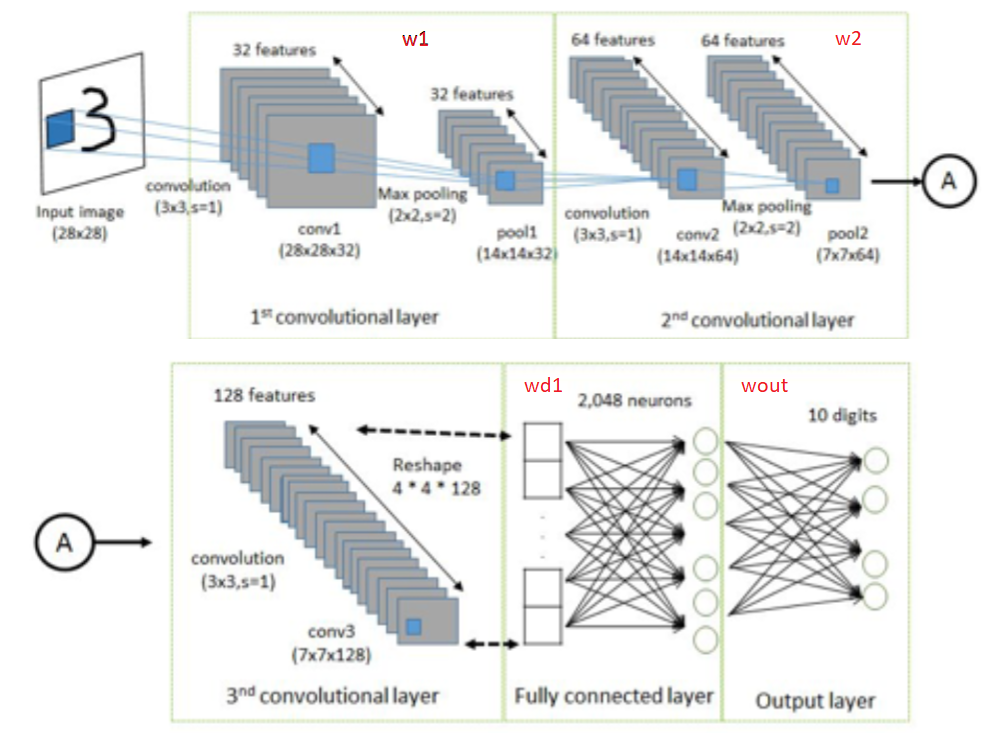

In [16]:
from IPython.display import Image
Image("img/fig1.png")

In [17]:
# Variáveis para os pesos e bias

# Pesos
# Cada neurônio da camada oculta é conectado a um pequeno grupo de tensores de entrada (input) de dimensão 5x5. Com isso, a camada oculta terá um tamanho de 24x24.
wc1 = tf.Variable(tf.random_normal([5, 5, 1, 32])) # 5x5 conv, 1 input, 32 outputs
wc2 = tf.Variable(tf.random_normal([5, 5, 32, 64])) # 5x5 conv, 32 inputs, 64 outputs
wd1 = tf.Variable(tf.random_normal([4*4*64, 1024])) # fully connected, 7*7*64 inputs, 1024 outputs
wout = tf.Variable(tf.random_normal([1024, n_classes])) # 1024 inputs, 10 outputs (class prediction)

# Bias
bc1 = tf.Variable(tf.random_normal([32]))
bc2 = tf.Variable(tf.random_normal([64]))
bd1 = tf.Variable(tf.random_normal([1024]))
bout = tf.Variable(tf.random_normal([n_classes]))

In [18]:
# Camada 1 de convolução
conv1 = conv2d(_X, wc1, bc1)

# Max Pooling (down-sampling)
conv1 = max_pool(conv1, k=2)

# Aplicando o Dropout
conv1 = tf.nn.dropout(conv1, keep_prob)

# Camada 2 de convolução
conv2 = conv2d(conv1,wc2,bc2)

# Max Pooling (down-sampling)
conv2 = max_pool(conv2, k=2)

# Aplicando o Dropout
conv2 = tf.nn.dropout(conv2, keep_prob)

# Camada totalmente conectada
dense1 = tf.reshape(conv2, [-1, wd1.get_shape().as_list()[0]]) # Reshape conv2 output to fit dense layer input
dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, wd1),bd1)) # Ativação com a Relu 
dense1 = tf.nn.dropout(dense1, keep_prob) # Aplicando Dropout

# Output, class prediction
pred = tf.add(tf.matmul(dense1, wout), bout)

In [19]:
# Cost Function e Otimização
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# Avaliando o Modelo
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Inicializando as variáveis
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [20]:
# Sessão
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Mantém o treinamento até atingir o número máximo de iterações
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training usando batch data
        sess.run(optimizer, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculando a acurácia
            acc = sess.run(accuracy, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculando a perda
            loss = sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 1.})
            print ("Iteração " + str(step*batch_size) + ", Perda = " + "{:.6f}".format(loss) + ", Acurácia em Treino = " + "{:.5f}".format(acc))
        step += 1
    print ("Otimização Concluída!")
    # Calculando acurácia para 256 mnist test images
    print ("Acurácia em Teste:", sess.run(accuracy, feed_dict = {x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.}))



Iteração 1280, Perda = 17868.361328, Acurácia em Treino = 0.13281
Iteração 2560, Perda = 15025.143555, Acurácia em Treino = 0.20312
Iteração 3840, Perda = 11915.865234, Acurácia em Treino = 0.31250
Iteração 5120, Perda = 8409.136719, Acurácia em Treino = 0.46875
Iteração 6400, Perda = 5003.100098, Acurácia em Treino = 0.54688
Iteração 7680, Perda = 5570.151367, Acurácia em Treino = 0.62500
Iteração 8960, Perda = 3321.610352, Acurácia em Treino = 0.66406
Iteração 10240, Perda = 3283.925049, Acurácia em Treino = 0.70312
Iteração 11520, Perda = 2292.055176, Acurácia em Treino = 0.69531
Iteração 12800, Perda = 3297.353271, Acurácia em Treino = 0.70312
Iteração 14080, Perda = 2303.503662, Acurácia em Treino = 0.71094
Iteração 15360, Perda = 1957.139893, Acurácia em Treino = 0.74219
Iteração 16640, Perda = 2221.068359, Acurácia em Treino = 0.82031
Iteração 17920, Perda = 1510.200562, Acurácia em Treino = 0.82031
Iteração 19200, Perda = 1702.288330, Acurácia em Treino = 0.82031
Iteração 20480